# Compute the coast line

From the NEMO mask, builds the coastline for nice maps with the real coastline of the ocean model.

Tested with **ORCA2.3**, **eORCA1.2**, **eORCA025**, **eORCA1.4.2** and **paleo ORCA2.3 90Ma**

Olivier Marti - olivier.marti@lsce.ipsl.fr - 2022/08/28

# Licence 
This software is governed by the CeCILL  license under French law and abiding by the rules of distribution of free software.  You can  use, modify and/ or redistribute the software under the terms of the CeCILL license as circulated by CEA, CNRS and INRIA at the following URL "http://www.cecill.info".

Warning, to install, configure, run, use any of Olivier Marti's software or to read the associated documentation you'll need at least one (1) brain in a reasonably working order. Lack of this implement will void any warranties (either express or implied). O. Marti assumes no responsability for errors, omissions, data loss, or any other consequences caused directly or indirectly by the usage of his software by incorrectly or partially configured personal. Please be aware that the author himself may not respect the prerequisites.

In [1]:
import importlib
import os
import platform
import datetime
from typing import List
import numpy as np
import xarray as xr
from plotIGCM import nemo
import matplotlib.pyplot as plt
#import matplotlib as mpl
import cartopy.mpl.ticker
import cartopy.crs as ccrs
import cartopy 
from matplotlib.path import Path
import matplotlib.patches as mpatches
import shapely as shp

# Choose ORCA config

In [2]:
importlib.reload (nemo)
#nemo.set_options (Debug=True)

f_Mask=None ; f_Mesh=None ; f_Coord=None

#f_Mask  = '/Users/marti/GRAF/DATA/ORCA2.3_coordinates_mask.nc'
#f_Coord = '/Users/marti/GRAF/DATA/coordinates_ORCA2.3.nc'
#cfg_name =  Model = 'orca2.3'
#domain = nemo.Domain (cfg_name=cfg_name)

f_Mask  = '/Users/marti/GRAF/DATA/eORCA1.2_mesh_mask.nc' 
f_Coord = '/Users/marti/GRAF/DATA/eORCA1.2_coordinates_mask.nc'
f_Mesh  = '/Users/marti/GRAF/DATA/eORCA1.2_mesh_mask.nc'
cfg_name = 'eorca1.2'
domain = nemo.Domain (cfg_name=cfg_name)

#f_Mask  = '/Users/marti/GRAF/DATA/eORCA1.2_mesh_mask.nc' 
#f_Coord = '/Users/marti/GRAF/DATA/eORCA1.2_coordinates_mask.nc'
#f_Mesh  = '/Users/marti/GRAF/DATA/eORCA1.2_mesh_mask.nc'
#cfg_name = 'eorca1.4'
#domain = nemo.Domain (cfg_name=cfg_name)

#f_Mask = '/Users/marti/GRAF/DATA/orca2.3_lgm.nc'
#f_Coord = f_Mask
#cfg_name = 'orca2.3_lgm'
#domain = nemo.Domain (cfg_name='orca2.3')

#f_Mask  = '/Users/marti/GRAF/DATA/eORCA025_coordinates_mask.nc' 
#f_Coord = '/Users/marti/GRAF/DATA/eORCA025_coordinates.nc'
#cfg_name='eorca025'
#domain = nemo.Domain (cfg_name=cfg_name)

#f_Mask  = '/Users/marti/Data/MOSAIXLGM/MOSAIX90Ma/ORCA2.3_paleo90MA_coordinates_mask.nc' 
#f_Coord = '/Users/marti/Data/MOSAIXLGM/MOSAIX90Ma/coordinates_paleo90MA.nc'
#cfg_name='ORCA2.3_paleo90MA'
#domain = nemo.Domain (cfg_name='orca2.3', Iperio=True, Jperio=True, NFold=True, NFtype='F', Halo=True)

#f_Mask  = '/Users/marti/Data/PaleoOrca2/new_deepmip_corr_standard_coordinates_mask.nc'
#f_Coord = f_Mask ; cfg_name='orca2_deepmip'
#domain = nemo.Domain (cfg_name=cfg_name, Iperio=True, Jperio=True, NFold=True, NFtype='F', Halo=True)

#f_Mask = '/Users/marti/Scratch/paleorca1_deepmip_v1_coordinates_mask.nc'
#f_Coord = f_Mask
#cfg_name='orca2_deepmip'
#domain = nemo.Domain (cfg_name=cfg_name, Iperio=True, Jperio=True, NFold=True, NFtype='F', Halo=False)

#f_Mask  = '/Users/marti/GRAF/DATA/eORCA1.4.2_ClosedSeasNew_ModifStraits_mesh_mask.nc'
#f_Coord = '/Users/marti/GRAF/DATA/eORCA1.4.2_ClosedSeasNew_ModifStraits_domain_cfg.nc' 
#cfg_name ='eorca1.4.2'
#domain = nemo.Domain (cfg_name=cfg_name)

In [3]:
domain

{'cfg_name': 'eorca1.2', 'CFG_name': 'eORCA1.2', 'cd_cfg': 'orca', 'kk_cfg': 1, 'jpk': 75, 'jpj': 332, 'jpi': 362, 'Iperio': True, 'Jperio': False, 'NFold': True, 'NFtype': 'F', 'nperio': 6, 'aperio': 6, 'Halo': True, 'Cyclic': None, 'ForceDefaults': False}

## Reading the input file(s)

In [4]:
if f_Mask : 
    d_Mask = xr.open_dataset (f_Mask, decode_times=False).squeeze()
else :
    d_Mask = None
if f_Coord == f_Mask : d_Coord = d_Mask
else                 : 
    if f_Coord :
        d_Coord = xr.open_dataset (f_Coord, decode_times=False).squeeze()
    else :
        d_Coord = None
if f_Mesh : 
    d_Mesh = xr.open_dataset (f_Mesh, decode_times=False).squeeze()
else :
    d_Mesh = None
    
udims   = nemo.UDIMS
if d_Coord : 
    d_Coord = nemo.unify_dims (d_Coord, **udims)
if d_Mask :
    d_Mask  = nemo.unify_dims (d_Mask , **udims)
    if 'x_grid_T' in d_Mask.dims : d_Mask = d_Mask.rename ( {'x_grid_T':udims['x']} )
    if 'y_grid_T' in d_Mask.dims : d_Mask = d_Mask.rename ( {'y_grid_T':udims['y']} )

### Compute grids boxes caracteristics : mask and position of corners

In [5]:
# Masks at center of the grid boxes
# Coordinates of the corners of the grid boxes
for dd in [d_Coord, d_Mesh, d_Mask] : 
    if dd is not None :
        if 'tmask' in  dd.variables : 
            print ( 'Reading tmask' )
            maskC = xr.where ( dd.tmask[0]>0.5, 1.0, 0.0 )
        if 'mask_T' in  dd.variables : 
            print ( 'Reading mask_T' )
            maskC = xr.where ( dd.mask_T>0.5, 1.0, 0.0 ) 
        if 'glamf' in dd.variables : 
            print ( 'using glamf')
            lonE = dd.glamf          
            latE = dd.gphif
        if 'nav_lon_grid_F' in dd.variables : 
            print ( 'using nav_lon_grid_F')
            lonE = dd.nav_lon_grid_F
            latE = dd.nav_lat_grid_F

maskC = nemo.lbc (maskC, cd_type='T', domain=domain)


Reading mask_T
Reading tmask
using glamf
Reading tmask
using glamf


### If needed (for NEMO $\ge$ 4.2)

The algorithm needs that periodicity and north folding points are present.
`nemo.lbc_add` adds these points for such configurations.

In [6]:
importlib.reload (nemo)
tdom = domain
jpj, jpi = maskC.shape

if not domain.Halo :
    maskC = nemo.lbc_add (maskC, cd_type='T', domain=domain, Debug=True)
    lonE  = nemo.lbc_add (lonE , cd_type='F', domain=domain)
    latE  = nemo.lbc_add (latE , cd_type='F', domain=domain)
    jpj, jpi = maskC.shape
    tdom  = nemo.Domain (Halo=True, jpi=jpi, jpj=jpj, domain=domain)
        
lonE = nemo.clo_lon (lonE, 0.)

### Simple test plot

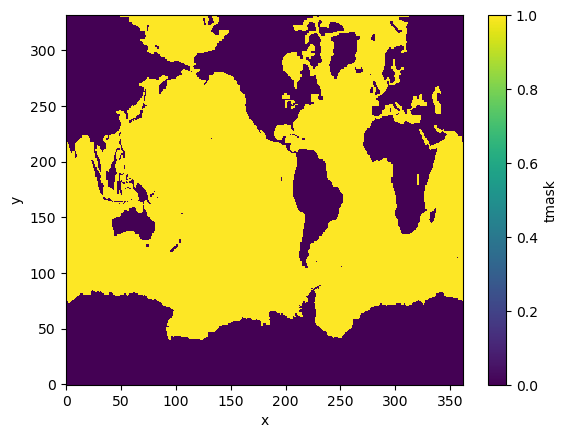

In [7]:
maskC.plot()

## A few utilities

In [8]:
def backward (direction) :
    match direction :
        case 'west'  : backward = 'east'
        case 'east'  : backward = 'west'
        case 'north' : backward = 'south'
        case 'south' : backward = 'north'    
    return backward

def toright (direction) :
    match direction : 
        case 'west'  : toright = 'north'
        case 'east'  : toright = 'south'
        case 'north' : toright = 'east'
        case 'south' : toright = 'west'
    return toright

def toleft (direction) :
    match direction :
        case 'west'  : toleft  = 'south'
        case 'east'  : toleft  = 'north'
        case 'north' : toleft  = 'east'
        case 'south' : toleft  = 'west'
    return toleft

def next_p (j, i, direction) :
    j_n=j ; i_n=i
    match direction : 
        case 'west'  : j_n = j   ; i_n = i-1
        case 'east'  : j_n = j   ; i_n = i+1
        case 'north' : j_n = j+1 ; i_n = i
        case 'south' : j_n = j-1 ; i_n = i
    j_n, i_n = nemo.lbc_index (jj=j_n, ii=i_n, jpj=jpj, jpi=jpi, domain=tdom, cd_type='F')
    return j_n, i_n

# Build coastline identifiers
`cote_west` is true if the point is coastal and the next point on his right (on his "west" side) is also a coastal point, on the same coast, with the coast on the left (on the "south")

On most points, we will find 1 possible direction. A few problematic points have 2 possible directions.

In [9]:
def cote_dir_comp (maskC) :
    cote_west  = xr.where(np.logical_and(np.logical_not(maskC.roll(y= 0,x= 0, roll_coords=False)), 
                                                        maskC.roll(y=-1,x= 0, roll_coords=False)),
                          True, False)
    cote_east  = xr.where(np.logical_and(               maskC.roll(y= 0,x=-1, roll_coords=False),
                                         np.logical_not(maskC.roll(y=-1,x=-1, roll_coords=False))),
                          True, False)  
    cote_north = xr.where(np.logical_and(np.logical_not(maskC.roll(y=-1,x= 0, roll_coords=False)), 
                                                        maskC.roll(y=-1,x=-1, roll_coords=False)),
                          True, False) 
    cote_south = xr.where(np.logical_and(               maskC.roll(y= 0,x= 0, roll_coords=False), 
                                         np.logical_not(maskC.roll(y= 0,x=-1, roll_coords=False))),
                          True, False) 
 
    cote_west  = nemo.lbc (cote_west , cd_type='F', domain=tdom)
    cote_east  = nemo.lbc (cote_east , cd_type='F', domain=tdom)
    cote_north = nemo.lbc (cote_north, cd_type='F', domain=tdom)
    cote_south = nemo.lbc (cote_south, cd_type='F', domain=tdom)

    cote_dir = xr.concat ([cote_west, cote_east, cote_north, cote_south], dim='direction')
    cote_dir = cote_dir.assign_coords (direction=['west', 'east', 'north', 'south'])
    cote_dir.name = 'Direction'
    return cote_dir
    
cote_dir   = cote_dir_comp (maskC)
cote_total = cote_dir.sum (dim='direction')
coastal_points = np.where (cote_total>0)

### Plot the number of possible direction(s) at each point

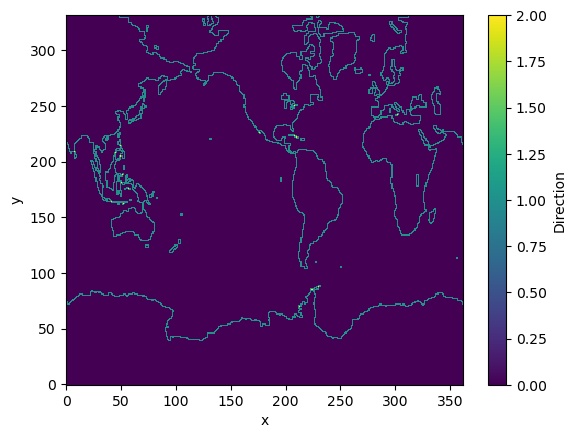

In [10]:
cote_dir.sum(dim='direction').plot(cmap='viridis')

## The real work

In [11]:
importlib.reload (nemo)

## Compute directions
cote_dir = cote_dir_comp (maskC)

## Count the number of directions for each point
cote_total = cote_dir.sum (dim='direction')

## We start from 0
i_start = 0

# Get first coastal point to start
j_zero, i_zero = nemo.lbc_index (jj=coastal_points[0][i_start], ii=coastal_points[1][i_start],
                                 jpj=jpj, jpi=jpi, domain=tdom, cd_type='F')
print ( f'coastal points:{len(coastal_points[0])} / starting point: jzero={j_zero.item()}, i_zero={i_zero.item()}')
j_s, i_s = j_zero, i_zero

# Intialize the list of points indexes, points longitudes and latitudes
list_lat    = [ latE.values[j_zero, i_zero] ]
list_lon    = [ lonE.values[j_zero, i_zero] ]
list_idx    = [            [j_zero, i_zero] ]
list_j = [j_zero] ; list_i = [i_zero]

# To numerate land masses
i_land      = 1
list_land   = [i_land]  # To numerate land masses
list_inner  = [0] # 1 if inner water body (lake, closed sea)

# Bad trick to have the first land mass (Antartica) in the same longitude range than the others
if 'orca2' in cfg_name : list_lon = [ nemo.clo_lon(lonE.values[j_zero, i_zero], 100.0) ] 

# Initialize indexes and indicators
# lastd is the last used direction
j_p, i_p = j_zero, i_zero ; new=True ; lastd='None' 

n = 0
while True :
    n += 1
    ## new == True if we start to circle a new land mass
    if new : j_s, i_s = j_p, i_p
    #print ( f'{n=:<5d} {j_p=:<4d} {i_p=:<4d} {lastd=:<5s} cote_total:{cote_total[j_p, i_p].values:<2d}', end=' ')

    found=False ; new=False ; nextd = 'None'

    # Always tries to turn right first, with respect to direction of previous move.
    match lastd :
        case 'west'  : order = ['north', 'west' , 'south', 'east' ]
        case 'east'  : order = ['south', 'east' , 'north', 'west' ]
        case 'north' : order = ['east' , 'north', 'west' , 'south']
        case 'south' : order = ['west' , 'south', 'east' , 'north']
        case   _     : order = ['north', 'west' , 'south', 'east' ] # Active if last_d == None
    
    # Search the direction of the next point. We must not go backward
    for direction in order :
        if not found and cote_dir.sel (direction=direction) [j_p, i_p] : 
            found = True ; nextd=direction
            j_n, i_n = next_p (j_p, i_p, direction)
                     
    #print ( f'nextd:{nextd:<6s} lon:{lonE[j_n, i_n].values:<5.1f} lat:{latE[j_n, i_n].values:<5.1f} list_land:{list_land[-1]:4<d}', end='') 
    
    if found : 
        cote_dir.sel (direction=nextd)[j_p, i_p] = False
        cote_dir = nemo.lbc (cote_dir, domain=tdom, cd_type='F')
        list_lon.append  ( lonE.values[j_n, i_n] )
        list_lat.append  ( latE.values[j_n, i_n] )
        list_idx.append  ( [j_n, i_n] )
        list_j.append (j_p) ; list_i.append (j_p)
        list_land.append ( i_land )
        list_inner.append ( 0)
        list_lon [-1] = nemo.clo_lon (list_lon[-1], list_lon[-2]) # Avoid too much jump across periodicity
        j_p, i_p = j_n, i_n
        lastd = nextd ; nextd='None' ; new=False
        #print ( f' list_land:{list_land[-1]:<4d}' )

    else : # We have circled around the land mass. Let jump to a new one
        # Insert a dummy point to break the line
        list_lon.append (np.nan)
        list_lat.append (np.nan)
        list_idx.append ( [-99, -99] )
        list_j.append (-99) ; list_i.append (-99)
        list_land.append (0)
        list_inner.append (0)
       
        cote_total = cote_dir.sum (dim='direction')
        # Search if non addressed coastal points still exists
        nn = np.where (cote_total>=1)
        if len (nn[0]) == 0 :
            print ()
            print ('All points processed')
            break
        else :
            # Takes the first non-addressed coastal point
            #print ()
            new=True  # Starting a new land mass
            lastd='None'
            # Take the first point in nn. Put it back in the 'inner' ORCA domain
            # (not at the periodicity or north pole folding).
            j_p, i_p = nemo.lbc_index (jj=nn[0][0], ii=nn[1][0], jpj=jpj, jpi=jpi, domain=tdom, cd_type='F')
            print ( f'New start {n=:<5d} {j_p=:<4d} {i_p=:<4d} cote_total:{cote_total[j_p, i_p].values} cote_dir:{cote_dir[:, j_p, i_p].values} liste_land:{list_land[-2]}' )
            i_land += 1
            list_lon.append  ( nemo.clo_lon (lonE[j_p, i_p], 0.) )
            list_lat.append  ( latE.values[j_p, i_p] )
            list_idx.append ([j_p, i_p])
            list_j.append (j_p) ; list_i.append (j_p)
            list_land.append (i_land)
            list_inner.append (0)
        
print ( f'Length : {len(list_lon)} - Land masses : {i_land}' )

list_lon    = np.transpose (np.array(list_lon))
list_lat    = np.transpose (np.array(list_lat))
list_idx    = np.transpose (np.array(list_idx))
list_j      = np.array (list_j)
list_i      = np.array (list_i)
list_land   = np.array (list_land)
list_inner  = np.array (list_inner)

coastal points:5178 / starting point: jzero=39, i_zero=93
New start n=741   j_p=104  i_p=217  cote_total:1 cote_dir:[False  True False False] liste_land:1
New start n=1946  j_p=105  i_p=250  cote_total:1 cote_dir:[False  True False False] liste_land:2
New start n=1951  j_p=109  i_p=227  cote_total:1 cote_dir:[False  True False False] liste_land:3
New start n=1956  j_p=113  i_p=356  cote_total:1 cote_dir:[False  True False False] liste_land:4
New start n=1961  j_p=118  i_p=94   cote_total:1 cote_dir:[False  True False False] liste_land:5
New start n=1990  j_p=123  i_p=72   cote_total:1 cote_dir:[False  True False False] liste_land:6
New start n=2001  j_p=126  i_p=102  cote_total:1 cote_dir:[False  True False False] liste_land:7
New start n=2014  j_p=129  i_p=68   cote_total:1 cote_dir:[False  True False False] liste_land:8
New start n=2177  j_p=134  i_p=306  cote_total:1 cote_dir:[False  True False False] liste_land:9
New start n=3710  j_p=144  i_p=332  cote_total:1 cote_dir:[False  Tru

## Find inland water bodies

In [12]:
def IsIn (lon:np.ndarray, lat:np.ndarray, lon0:float|int=0, lat0:float|int=90) -> np.bool : 
    '''
    True if a specific sea point is in the polygon
    Default sea point is North pole
    
    Uses cumul of vector product of adjacent pairs :
       a point is in the polygon is this sum is negative
    '''
    dlon = lon-lon0
    dlat = lat-lat0
    prod = 0.
    for i in np.arange (len(dlon)) :
        dp =  (dlon[i-1]*dlat[i]-dlat[i-1]*dlon[i])
        prod = prod + dp
    return prod < 0.

n_mass = np.max (list_land)

for n_m in np.arange(n_mass)+1 :
    idx = np.where (list_land == n_m)
    nn = len(idx[0])
    if nn > 0 : 
        lon = np.array (list_lon[idx]) ; lat = np.array (list_lat[idx])
        indic = IsIn (lon, lat)
        print ( f'{n_m=:>3d},  lon mean: {lon.mean():>-6.1f}, lat mean : {lat.mean():>-6.1f},  {indic=}' )
        if indic : 
            #list_lon   [idx[0]] = lon[::-1]
            #list_lat   [idx[0]] = lat[::-1]
            list_inner [idx[0]] = 1

type(lon), type(lat), type(indic)

n_m=  1,  lon mean:  -10.7, lat mean :  -71.4,  indic=np.False_
n_m=  2,  lon mean:  -89.6, lat mean :   34.7,  indic=np.False_
n_m=  3,  lon mean:  -36.6, lat mean :  -54.4,  indic=np.False_
n_m=  4,  lon mean:  -59.6, lat mean :  -52.0,  indic=np.False_
n_m=  5,  lon mean:   69.4, lat mean :  -49.5,  indic=np.False_
n_m=  6,  lon mean:  170.4, lat mean :  -44.0,  indic=np.False_
n_m=  7,  lon mean:  146.4, lat mean :  -42.2,  indic=np.False_
n_m=  8,  lon mean:  175.9, lat mean :  -39.2,  indic=np.False_
n_m=  9,  lon mean:  134.6, lat mean :  -24.9,  indic=np.False_
n_m= 10,  lon mean:   62.5, lat mean :   34.7,  indic=np.False_
n_m= 11,  lon mean:   46.7, lat mean :  -19.4,  indic=np.False_
n_m= 12,  lon mean:  177.9, lat mean :  -17.8,  indic=np.False_
n_m= 13,  lon mean:  120.4, lat mean :   -9.9,  indic=np.False_
n_m= 14,  lon mean:  125.3, lat mean :   -9.2,  indic=np.False_
n_m= 15,  lon mean:  139.8, lat mean :   -5.1,  indic=np.False_
n_m= 16,  lon mean:  110.5, lat mean :  

(numpy.ndarray, numpy.ndarray, numpy.bool)

## Very simple demo plot
With no projection

Text(0.5, 1.0, 'eorca1.2')

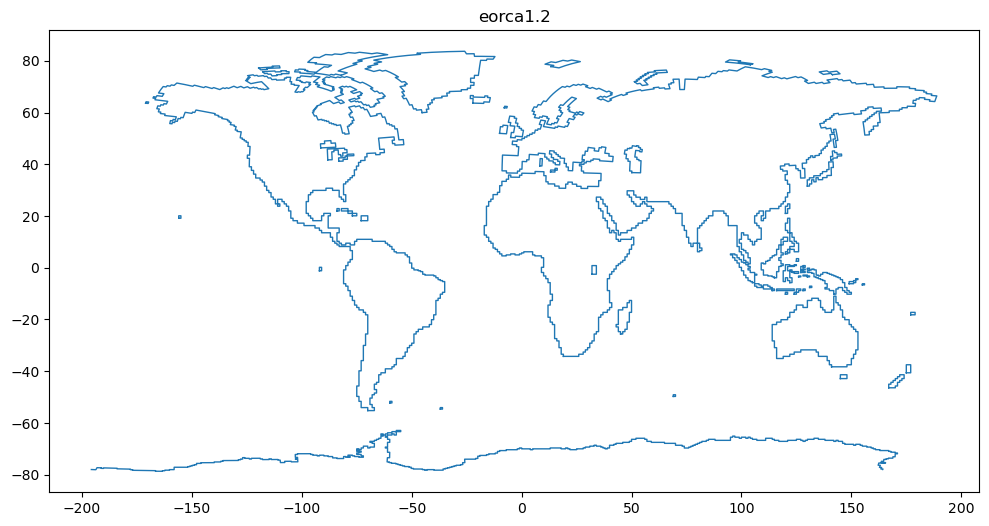

In [13]:
fig = plt.figure (figsize=(12,6))

ax = fig.add_subplot (111)
nn=1571
ax.plot (list_lon[:], list_lat[:], linewidth=1)
ax.set_title (cfg_name)

# Build shapely structures

Theses structures will allow to plot ORCA coast and land masses in any projection with matplotlib/cartopy.

We need to build two stuctures, one for the coastline, and one for the land masses. There is no way to have the same structure that will give neat plots for both coast and land masses, for any projection. Sea https://github.com/SciTools/cartopy/issues/2550 for some details. Cartopy itself had `cartopy.feature.LAND` and `cartopy.feature.COASTLINE`

## Build land masses and inner water bodies

In [14]:
n_mass  = list_land.max().item()
holes_coast   = []
corners_coast = []

holes_land   = []
corners_land = []

holes_sea    = []
corners_sea  = []

for nm in np.arange (1,n_mass+1) :
    pts = np.where (list_land == nm)[0]
    list_lon_mass = list_lon[pts][:]
    list_lat_mass = list_lat[pts][:]

    # First land mass is Antartica, which needs a special treatment for neat maps
    if nm == 1 : 
        print ( 'rien')
        list_lon_mass = list_lon[pts][:]
        list_lat_mass = list_lat[pts][:]
        poly_corners       = np.stack ( [list_lon_mass[:]   , list_lat_mass[:]   ]).T
        poly_corners_rev   = np.stack ( [list_lon_mass[::-1], list_lat_mass[::-1]]).T
        poly_corners_land  = np.vstack ( [poly_corners    , np.array( [(list_lon_mass [-1], -90), (list_lon_mass [ 0], -90)])])
        
        #poly_corners_sea    = poly_corners_rev # En carré pas d'Antarctique. A l'envers en polaire.
        #poly_corners_sea    = np.vstack ( [poly_corners_rev, np.array([(list_lon_mass [0], list_lat_mass[0])])]) # En carré pas d'Antarctique. A l'envers en polaire.     
        #poly_corners_sea   = np.vstack ( [poly_corners_rev, np.array( [(list_lon_mass  [0],  90), (180,  90), (-180,  90), (list_lon_mass [-1], 90)])]) # Toutes projections inversées
        #poly_corners_sea   = np.vstack ( [poly_corners_rev, np.array( [(list_lon_mass  [0],  -90), (180,  -90), (-180, -90), (list_lon_mass [-1], -90)])])  # Toutes projections inversées
        #poly_corners_sea   = np.vstack ( [poly_corners_rev, np.array( [(list_lon_mass  [0],  -80), (180, -80), (180,  90), (-180,  90), (-180, list_lat_mass [-1]) ] ) ] ) # En carré seulement Antarctique et mer fermées. OK en polaire.
        #poly_corners_sea   = np.vstack ( [poly_corners_rev, np.array( [(list_lon_mass  [0],  -80), (180, -80), (180,  90), (-180,  90), (-180, list_lat_mass [-1]), (list_lon_mass[-1], list_lat_mass [-1])] ) ] )

        #poly_corners_sea    = poly_corners
        #poly_corners_sea    = np.vstack ( [poly_corners, np.array([(list_lon_mass [-1], list_lat_mass[-1])])]) # En carré pas d'Antarctique. A l'envers en polaire. 
        poly_corners_sea   = np.vstack ( [poly_corners_rev, np.array( [(list_lon_mass  [0],  -80), (180, -80), (180,  90), (-180,  90), (-180, list_lat_mass [-1]) ] ) ] ) # En carré seulement Antarctique et mer fermées. En polaire seulement Antarctique.

        poly_corners_coast = np.vstack ( [poly_corners, np.array([(list_lon_mass [-1], list_lat_mass[-1])])])
        
    else : 
        #pts = np.append (pts, pts[0] )
        list_lon_mass = list_lon[pts][:]
        list_lat_mass = list_lat[pts][:]
        poly_corners_coast = np.stack ( [list_lon_mass[:], list_lat_mass[:]   ]).T
        poly_corners_land = poly_corners_coast
        #poly_corners_sea  = poly_corners_land
        poly_corners_sea   = np.stack ( [list_lon_mass[::-1], list_lat_mass[::-1]]).T
        
    corners_coast.append (poly_corners_coast)
    if list_inner[pts][0] == 1 :
        holes_land.append (poly_corners_land)
        holes_sea .append (poly_corners_sea )
    else : 
        corners_land.append (poly_corners_land)
        corners_sea .append (poly_corners_sea )

   

rien


## Write geojson file

In [15]:
def create_json (corners:List, holes:List|None, feat='Polygon', file_json=None) -> shp.geometry.multilinestring.MultiLineString|shp.geometry.multipolygon.MultiPolygon: 
    n_corner = len (corners)
    n_hole   = len (holes) if holes is not None else 0

    polys = []
    # Loop on water bodies
    for nc in np.arange (n_corner) :
        match feat : 
            case 'Polygon' : poly = shp.Polygon    (corners[nc])
            case 'Line'    : poly = shp.LineString (corners[nc])

        # Loop on inner water bodies
        if holes is not None :
            in_hole = []
            for nh in np.arange (n_hole) :
                if shp.Point (holes[nh][0]).within(poly):
                    in_hole.append (holes[nh])
                match feat : 
                    case 'Polygon' : poly = shp.Polygon    (corners[nc], in_hole)
                    case 'Line'    : poly = shp.LineString (corners[nc])
        polys.append (poly)

    match feat : 
        case 'Polygon' : coast_shp = shp.MultiPolygon    (polys)
        case 'Line'    : coast_shp = shp.MultiLineString (polys)

    if file_json is not None : 
        feat_shp = shp.to_geojson (coast_shp, indent=4)
        fic = open ( file_json, 'w')
        fic.write (feat_shp)
        fic.close ()
        
    return coast_shp

corners_sea.reverse()

coast_shp = create_json (corners=corners_coast, holes=None      , feat='Line'   , file_json=f'{cfg_name}_coast.json' )
land_shp  = create_json (corners=corners_land , holes=holes_land, feat='Polygon', file_json=f'{cfg_name}_land.json'      )
sea_shp   = create_json (corners=corners_sea  , holes=None , feat='Polygon', file_json=f'{cfg_name}_sea.json'       )

## Build cartopy feature

In [16]:
coast_poly = cartopy.feature.ShapelyFeature (coast_shp, ccrs.PlateCarree (), facecolor='none')
land_poly  = cartopy.feature.ShapelyFeature (land_shp , ccrs.PlateCarree (), facecolor='none')
sea_poly   = cartopy.feature.ShapelyFeature (sea_shp  , ccrs.PlateCarree (), facecolor='none')

In [32]:
CenLon = 0.0

ProjIn=ccrs.PlateCarree()

#ProjPlot=ccrs.PlateCarree(central_longitude=CenLon)
#ProjPlot=ccrs.Robinson(central_longitude=CenLon)
ProjPlot=ccrs.Orthographic(central_longitude=CenLon, central_latitude=-90)
#ProjPlot=ccrs.Stereographic             (central_longitude=CenLon, central_latitude=90)
#ProjPlot=ccrs.AzimuthalEquidistant      (central_longitude=CenLon)
#ProjPlot=ccrs.InterruptedGoodeHomolosine(central_longitude=CenLon)
#ProjPlot=ccrs.LambertAzimuthalEqualArea (central_longitude=CenLon)
#ProjPlot=ccrs.AlbersEqualArea           (central_longitude=CenLon), 
#ProjPlot=ccrs.Stereographic             (central_longitude=CenLon, central_latitude=40)
#ProjPlot=ccrs.Mollweide                 (central_longitude=CenLon)
#ProjPlot=ccrs.NorthPolarStereo          (central_longitude=CenLon)
#ProjPlot=ccrs.LambertConformal          (central_longitude=CenLon, cutoff=-30)
#ProjPlot=ccrs.Orthographic              (central_longitude=CenLon, central_latitude=90)
#ProjPlot=ccrs.EckertVI                  (central_longitude=CenLon)
#ProjPlot=ccrs.EquidistantConic          (central_longitude=CenLon)
#ProjPlot=ccrs.RotatedPole      (pole_longitude=CenLon, pole_latitude=60.0, central_rotated_longitude=CenLon)
#ProjPlot=ccrs.RotatedPole      (pole_longitude=CenLon, pole_latitude= 0.0, central_rotated_longitude=CenLon)

## Plot with projection

Warning : in recent version of Matpotlib, somme projection may fails. Limited to projection showing all the globe (Robinson, Molleweide)

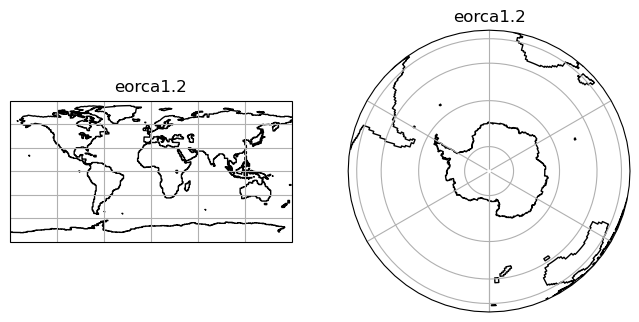

In [33]:
fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot (121, projection=ProjIn)
ax.set_title (cfg_name)
ax.add_feature (coast_poly, facecolor='none')
ax.gridlines  ()

ax = fig.add_subplot (122, projection=ProjPlot)
ax.set_title (cfg_name)
ax.add_feature (coast_poly, facecolor='none')
ax.gridlines  ()

## Plot with filling

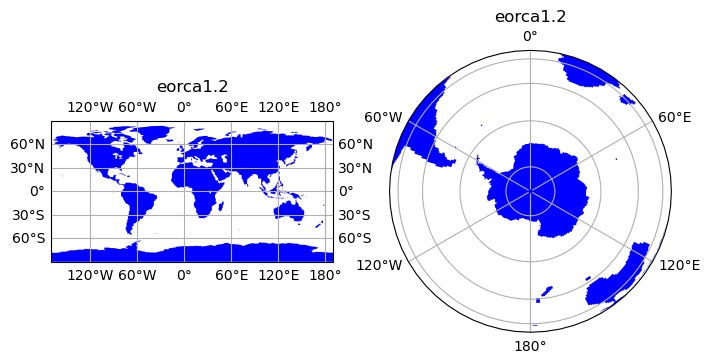

In [34]:
fig = plt.figure(figsize=(8,8))
ProjIn = ccrs.PlateCarree ()

ax = fig.add_subplot (121, projection=ccrs.PlateCarree(central_longitude=10))

ax.set_title (cfg_name)
ax.add_feature (land_poly, facecolor='blue')
ax.gridlines  (draw_labels=True)


ax = fig.add_subplot (122, projection=ProjPlot)
ax.set_title (cfg_name)
ax.add_feature (land_poly, facecolor='blue')
ax.gridlines  (draw_labels=True)


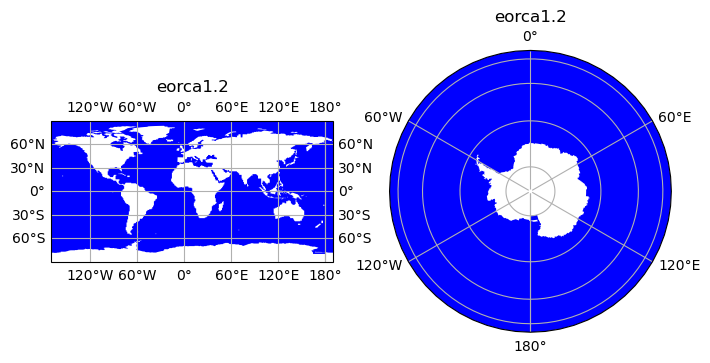

In [35]:
fig = plt.figure(figsize=(8,8))
ProjIn = ccrs.PlateCarree ()

ax = fig.add_subplot (121, projection=ccrs.PlateCarree(central_longitude=10))
ax.set_title (cfg_name)
ax.add_feature (sea_poly, facecolor='blue')
ax.gridlines  (draw_labels=True)

ax = fig.add_subplot (122, projection=ProjPlot)
ax.set_title (cfg_name)
ax.add_feature (sea_poly, facecolor='blue')
ax.gridlines  (draw_labels=True)

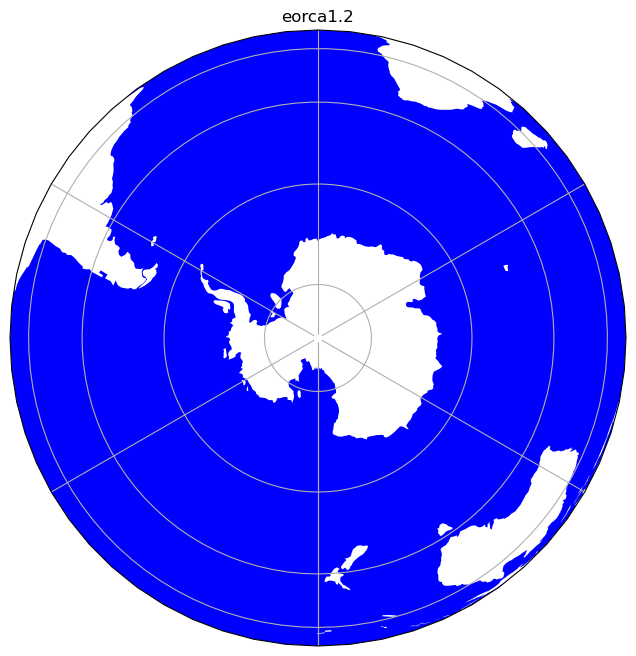

In [36]:
fig = plt.figure(figsize=(8,8))
ProjIn = ccrs.PlateCarree ()

ax = fig.add_subplot (111, projection=ProjPlot)

ax.set_title (cfg_name)
ax.add_feature (cartopy.feature.OCEAN, facecolor='blue')
ax.gridlines  ()

cartopy.feature.OCEAN

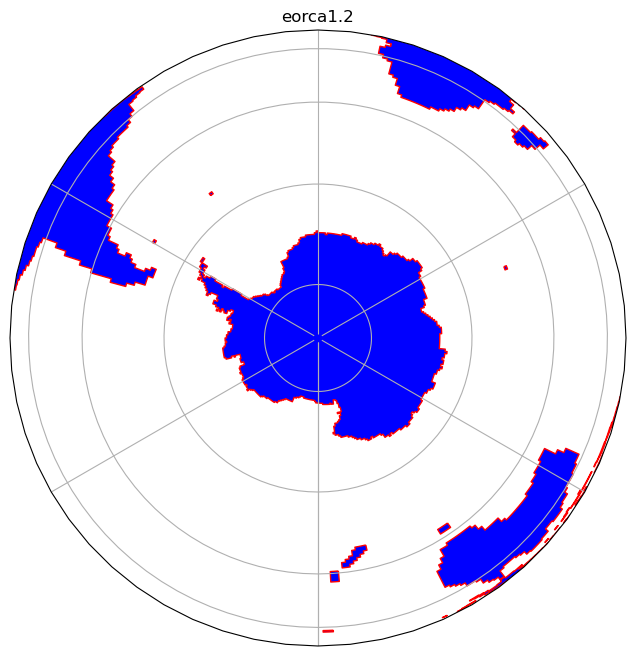

In [37]:
fig = plt.figure(figsize=(8,8))
ProjIn = ccrs.PlateCarree ()

ax = fig.add_subplot (111, projection=ProjPlot)

ax.set_title (cfg_name)
ax.add_feature (land_poly , facecolor='blue', edgecolor='none')
ax.add_feature (coast_poly, facecolor='none', edgecolor='red')

ax.gridlines  ()

## Using a path 
Work with all projection for the coastline

With filling, may work, or not, depending on the projection. Better with limited area.

In [38]:
codes = np.where (np.isnan(list_lon), Path.MOVETO, Path.LINETO)
codes[0] = Path.MOVETO
path = Path (np.stack([list_lon, list_lat]).T, codes)

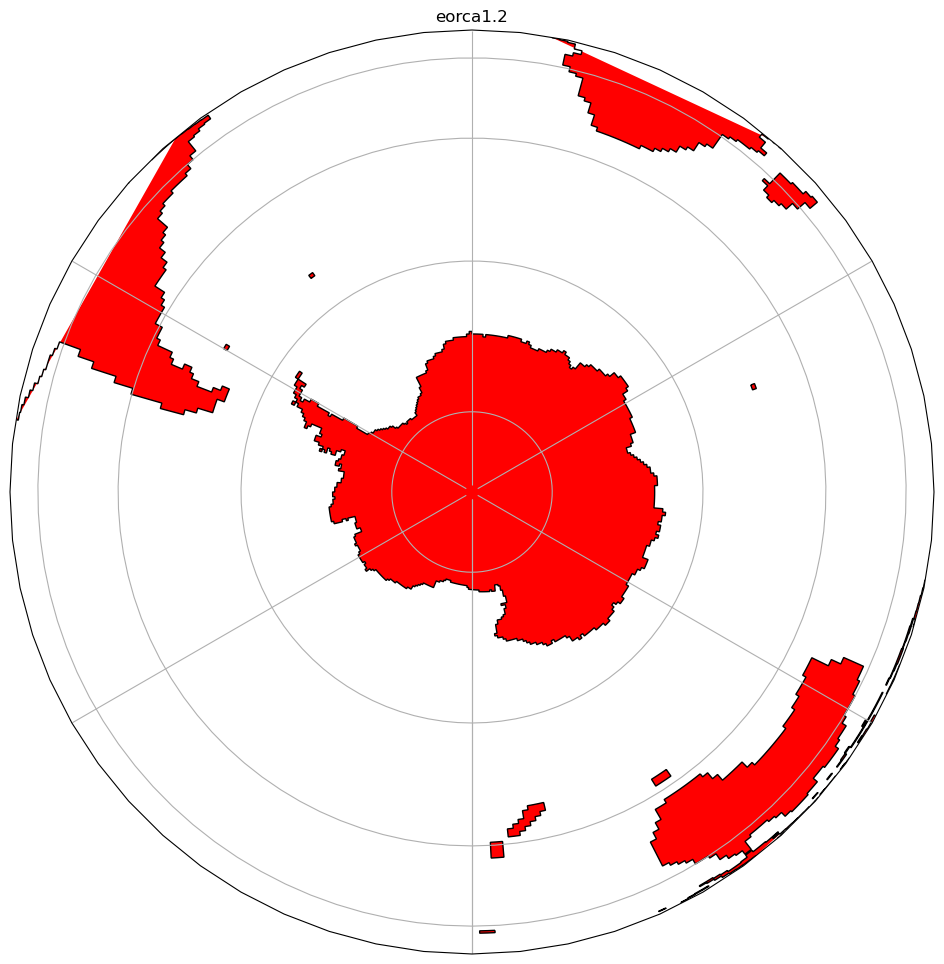

In [39]:
fig = plt.figure(figsize=(12,12))
ProjIn = ccrs.PlateCarree(central_longitude=0)

ax = fig.add_subplot (111, projection=ProjPlot)

ax.set_title (cfg_name)
ax.set_global ()
patch = mpatches.PathPatch (path, facecolor='red', lw=1, transform=ProjIn)
ax.add_patch (patch)
ax.gridlines  ()

# Write the result

In [40]:
list_lon = xr.DataArray (list_lon, dims = ['coastal_point',])
list_lat = xr.DataArray (list_lat, dims = ['coastal_point',])
list_lon.attrs.update ({'name':'Longitude', 'units':'degrees_east' , 'long_name':'Longitude of coast line'})
list_lat.attrs.update ({'name':'Latitude' , 'units':'degrees_north', 'long_name':'Latitude of coast line'  })

list_land = xr.DataArray ( list_land, dims = ['coastal_point',])
list_land.attrs.update ( {'long_name':'Land mass identifier'})

list_inner = xr.DataArray ( list_inner, dims = ['coastal_point', ])
list_inner.attrs['long_name'] = 'Inner water body (lake, closed sea, ...) indicator. 1 if inner water body, 0 else'

list_j = xr.DataArray ( list_j, dims = ['coastal_point', ] )
list_i = xr.DataArray ( list_i, dims = ['coastal_point', ] )
list_j.attrs.update ({'name':'IndexJ', 'long_name':'Index J'})
list_i.attrs.update ({'name':'IndexI', 'long_name':'Index I'})

OuFile = cfg_name + '_' + 'coast.nc'
list_geo = xr.Dataset ( {'lon_coast':list_lon, 'lat_coast':list_lat, 'land_mass':list_land, 'inner_water_body':list_inner, 
                          'IndexJ':list_j, 'IndexI':list_i})
list_geo.attrs.update ({'Description':'Coordinates of the coastline', 'File':OuFile,
                        'title':'Coordinates of the coastline', 'Conventions':"CF-1.6", 'source':"IPSL Earth system model",
                        'group':"ICMC IPSL Climate Modelling Center", 'Institution':"IPSL https://www.ipsl.fr", 'associatedFiles':[f_Coord, f_Mask],
                        'directory':os.getcwd (), 'description':"Generated with CoastLine.ipynb", 
                        'git':'https://github.com/oliviermarti/IPSLCM-Utilities',
                        'created':str(datetime.datetime.now().strftime('%A %d %B %Y @ %H:%M %Z')),
                        'HOSTNAME':platform.node (), 'LOGNAME':os.getlogin (), 'Python':f"Python version {platform.python_version ()}",
                        'OS':f'{platform.system()} {platform.release ()}', 'hardware':platform.machine () })

In [41]:
if os.path.exists (OuFile) : 
    os.remove (OuFile)

list_geo.to_netcdf ( OuFile, mode='w', encoding={
      "lon_coast"        : {'dtype': 'float32'},
      "lat_coast"        : {'dtype': 'float32'},
      "land_mass"        : {'dtype': 'int32'  },
      "inner_water_body" : {'dtype': 'int32'  },
      "IndexI"           : {'dtype': 'int32'  },
      "IndexJ"           : {'dtype': 'int32'  },
} )

In [42]:
dir (cartopy.feature.OCEAN)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__firstlineno__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__static_attributes__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_crs',
 '_kwargs',
 '_validate_scale',
 'category',
 'crs',
 'geometries',
 'intersecting_geometries',
 'kwargs',
 'name',
 'scale',
 'scaler',
 'with_scale']

In [118]:
cartopy.feature.LAND

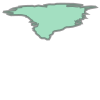

In [113]:
# 95 : Ameriques
# 112 : Eurasie
list ( cartopy.feature.LAND.geometries() )[126]

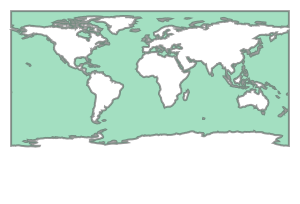

In [122]:
list ( cartopy.feature.OCEAN.geometries() )[1]

In [46]:
list ( cartopy.feature.OCEAN.geometries() )[1].exterior.coords.xy[1]

array('d', [71.51571433642826, 71.09880000000004, 70.78113999999997, 70.83219920854668, 68.96372213254719, 69.4000854492188, 69.87731933593747, 69.81750488281256, 70.09710693359378, 69.65289306640628, 69.01367187499997, 68.69390869140622, 69.58270263671878, 69.47210693359372, 69.66827392578122, 69.64208984375003, 69.43731689453125, 69.72210693359378, 70.45330810546878, 70.86669921875, 71.031494140625, 70.84228515625, 71.6065063476563, 72.20007324218756, 72.84948730468753, 72.41632080078125, 71.4879150390625, 71.62811279296875, 71.34771728515625, 71.6552734375, 71.38647460937503, 71.83630371093753, 70.78710937500006, 71.193115234375, 71.9801025390625, 72.398681640625, 73.03869628906253, 73.56549072265625, 73.56011962890622, 73.73510742187506, 72.97131347656247, 73.1201171875, 73.58770751953125, 73.75292968750003, 73.5949096679688, 73.3350830078125, 73.97692871093753, 73.78771972656253, 74.04010009765622, 74.18011474609372, 74.47668457031256, 75.03192138671872, 75.327880859375, 75.847717

In [47]:
list ( cartopy.feature.OCEAN.geometries() )[1].exterior.coords.xy

(array('d', [180.00000000000014, 178.72530000000003, 178.9034250000001, 180.00000000000014, 180.00000000000014, 178.60009765625003, 175.72412109374997, 173.64392089843764, 170.45349121093753, 170.00830078125003, 170.81689453125009, 169.57769775390634, 167.83569335937509, 165.94049072265634, 164.05249023437509, 162.27911376953134, 160.94067382812503, 159.70867919921884, 159.83032226562503, 158.99792480468759, 157.00689697265628, 152.96887207031259, 150.35131835937509, 149.50012207031253, 140.46807861328128, 139.14788818359378, 139.86987304687509, 138.23413085937509, 137.49768066406253, 135.56207275390628, 133.85772705078134, 132.25347900390628, 131.28869628906253, 129.71612548828134, 128.46008300781253, 129.05169677734384, 128.59130859375003, 126.97650146484384, 125.38012695312509, 123.25787353515628, 123.20068359375009, 119.02008056640634, 118.77630615234384, 115.56787109375009, 113.96887207031253, 113.52972412109378, 113.01947021484384, 112.11932373046878, 110.64007568359378, 109.4000